In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df = pd.read_pickle('female_test.pkl')
from scipy.stats import pearsonr
from sklearn.decomposition import FastICA
from scipy import linalg
from datetime import datetime
import scipy.io

In [2]:
subjects_to_be_ignored = [21269692]
subject_sex = 'female'
prototype_flag = True

deconfound_flag = False
if deconfound_flag == True:
    import matlab.engine
    eng = matlab.engine.start_matlab()
    
IDP_cuttoff_nan = 1.0
vars_cutoff_nan = 0.01

In [3]:
# Identify Correct File to Load

IDP_file = 'female_test_IDPs.h5'
confounds_file = 'female_test_conf12.h5'
data_file = 'female_test.pkl'

confounds = h5py.File(confounds_file, 'r')
confounds = confounds['conf12'][()]

IDP_h5 = h5py.File(IDP_file, 'r')
subjects_h5 = IDP_h5['subjects'][()]

# Load the relevant dataframe based on the required modality

df = pd.read_pickle(data_file)

IDP_h5 = h5py.File(IDP_file, 'r')
IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
vars_i_deconf = IDP_h5['vars_i_deconf'][()]
subjects_h5 = IDP_h5['subjects'][()]

# Useful Functions

# def deconfound_inputs(deltas):
    
#     confounds = h5py.File('ICA/male_test_conf12.h5', 'r')
#     confounds = confounds['conf12'][()]
    
#     deltas_deconfounds = eng.NetsUnconfoundWrapper(eng.transpose(matlab.double(deltas.tolist())), 
#                                   matlab.double(confounds.tolist()))
    
#     deltas_deconfounds = np.asarray(deltas_deconfounds).flatten()
    
#     return deltas_deconfounds

def deconfound_inputs(y):
    
    y = y - y.mean(axis=0)
    if np.sum(np.isnan(y)) == 0:
        beta = np.linalg.pinv(confounds).dot(y)
        beta[np.abs(beta) < 1e-10] = 0
        yd = y - confounds.dot(beta)
        yd = yd - yd.mean()
    else:
        print('ERROR! Encoundered a NaN! Function Needs Updating!')
    
    return yd

def apply_FDR_correction(p_values):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    Wrapper for Benjamini/Hochberg (non-negative) p-value correction for multiple tests.
    '''
    p_values_corrected = mt.multipletests(p_values, alpha=0.05, method='fdr_bh')[1] 
    
    return p_values_corrected


def standardize_data(variables):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    '''

    number_of_subjects=variables.shape[0]

    # Compute the arithmetic mean & std along the specified axis, ignoring NaNs.
    variables_mean_ignore_NaNs = np.nanmean(variables,axis=0)
    variables_std_ignore_NaNs = np.nanstd(variables,axis=0)

    # We standardize the data
    variables_scaled = variables - np.tile(variables_mean_ignore_NaNs,(number_of_subjects,1))
    variables_scaled = variables_scaled / np.tile(variables_std_ignore_NaNs,(number_of_subjects,1))

    # Calculate how many variables are non NaN
    number_of_non_NaN =np.sum(np.isnan(variables)==False,axis=0) #np.nanstd has N**0.5 in divisor

    return variables_scaled, number_of_non_NaN


def correlate_with_fdr_correction(deltas, ukb_variables):
    """
    Code addapted from Emma Bluemke & Nicola Dinsdale

    correlate age deltas with rows in ukb_variables
    returns pearson_r, t_test_statistic, p_values_corrected, p_values of length number_of_variables

    pearson_r = raw Pearson correlation value (between -1 and 1)
    t_test_statistic t test statistic for each variable ()
    p_values_corrected is corrected p-values values (fdr corrected)
    p_values is non corrected p-values
    """

    ukb_variables_scaled , ukb_variales_number_of_non_NaN = standardize_data(ukb_variables)
    ukb_variables_NaN_matrix = np.isnan(ukb_variables_scaled)
    ukb_variables_scaled[ukb_variables_NaN_matrix] = 0

    sys.stdout.flush()

    number_of_variables = ukb_variables_scaled.shape[1]

    deltas_array = np.tile(deltas,(number_of_variables,1)).T
    deltas_array[ukb_variables_NaN_matrix] = np.nan
    deltas_array = standardize_data(deltas_array)[0]
    deltas_array[ukb_variables_NaN_matrix] = 0

    pearson_r = np.sum(deltas_array * ukb_variables_scaled, axis=0) / ukb_variales_number_of_non_NaN
    
    t_test_statistic = pearson_r * ((ukb_variales_number_of_non_NaN-2)/(1-pearson_r**2))**0.5
    t_test_statistic = np.abs(t_test_statistic)
    t_test_statistic[ukb_variales_number_of_non_NaN <= 2] = np.nan #set those that had d.o.f 0 to nan

    p_values=np.zeros(len(t_test_statistic))
    for j in range(len(t_test_statistic)):
        if t_test_statistic[j] is not np.nan:
            p_values[j] = student_t.sf(t_test_statistic[j], ukb_variales_number_of_non_NaN[j] - 2) * 2
        else:
            p_values[j]=np.nan

    p_values_NaN_matrix = np.isnan(p_values)
    p_values_no_NaN = p_values[p_values_NaN_matrix==False]
    p_values_corrected_raw = apply_FDR_correction(p_values_no_NaN)

    p_values_corrected=np.zeros(len(p_values))
    p_values_corrected[p_values_NaN_matrix==False] = p_values_corrected_raw
    p_values_corrected[p_values_NaN_matrix==True] = np.nan

    return pearson_r, t_test_statistic, p_values_corrected, p_values

def align_subjects(subjects_df, subjects_h5, age_delta_decon, subjects_to_be_ignored):
    '''
    Here we make sure that the subjects match between the results and the nIDP/IDP dataframes
    The subjects_df uses slightly older data, and subjects might have left the study since it's generation
    If need be, this will be corrected at a later stage!
    '''
    
    if len(subjects_df) == len(subjects_h5):
        assert (subjects_df == subjects_h5).all()
    else:
        idx_elim = np.where(subjects_df == subjects_to_be_ignored)[0][0]
        subjects_df = np.delete(subjects_df, idx_elim)
        assert (subjects_df == subjects_h5).all()
        age_delta_decon = np.delete(age_delta_decon, idx_elim)
    return subjects_df, age_delta_decon

def correlations_and_plots(age_delta_decon, deconf_subset, names_subset, idxs, categories_subset, title, 
                           corr_flag='IDP'):
    
    corr_results = correlate_with_fdr_correction(age_delta_decon, deconf_subset)
    
    corr_df = pd.DataFrame.from_dict({
        'idx': idxs,
        "names": names_subset,
        'Categories': categories_subset,
        "pearson_r": corr_results[0],
        "t_test_statistic": corr_results[1],
        "p_values_corrected": corr_results[2],
        "p_values": corr_results[3],
        "abs_pearson_r": np.abs(corr_results[0]),
        "log_p_values": -np.log10(corr_results[3]),
        "log_p_values_corrected": -np.log10(corr_results[2]),
    })
    
    if corr_flag == 'IDP':
        short_p_values = np.extract(corr_df.p_values !=0, corr_df.p_values)
        bonferroni_threshold = 0.05/len(short_p_values) #... Bonferroni
    else:
        bonferroni_threshold = 0.05/len(corr_df.p_values) #... Bonferroni
    bonferroni_threshold = -np.log10(bonferroni_threshold)

    arguments = np.argsort(corr_df.p_values_corrected)
    sorted_p_values_corrected = corr_df.p_values_corrected[arguments]
    sorted_p_values = corr_df.p_values[arguments]
    if len(sorted_p_values_corrected[sorted_p_values_corrected<=0.05]):
#         arguments_no_NaN = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])        
#         false_discovery_rate = sorted_p_values[arguments_no_NaN]

        false_discovery_rate = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])
        false_discovery_rate = -np.log10(false_discovery_rate)
        FDR_flag = True
    else:
        FDR_flag = False
        false_discovery_rate = None

    if corr_flag == 'IDP':
        x_text_location = -120
        bonferroni_threshold_text = 1
        false_discovery_rate_text = -2
        colorCycle = 'Paired'
    else:
        x_text_location = -750
        bonferroni_threshold_text = 0.1
        false_discovery_rate_text = -0.5
        colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
#         colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']


    
    
    plt.figure(figsize=(16, 9.6))
    
    if corr_flag == 'IDP':
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )
    else:
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )  
    
    plt.ylabel('-log(P)')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='r')
    plt.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.')
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r')
        plt.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.show()
    
    return corr_df, bonferroni_threshold, false_discovery_rate



IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')
with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')

IDPIDX = np.arange(0, len(IDP_names), 1).astype(int)
varsIDX = np.arange(0, len(varsHeader), 1).astype(int)

# # Identify Correct File to Load

# data_file = 'male'
# IDP_file = 'male'
# if subject_sex == 'female':
#     data_file = 'fe' + data_file
#     IDP_file = 'fe' + IDP_file
# if prototype_flag == True:
#     data_file += '_prototype'
# data_file += '.pkl'
# IDP_file += '_test_IDPs.h5'

# # Load the relevant dataframe based on the required modality

# df = pd.read_pickle(data_file)

# IDP_h5 = h5py.File(IDP_file, 'r')
# IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
# vars_i_deconf = IDP_h5['vars_i_deconf'][()]
# subjects_h5 = IDP_h5['subjects'][()]

# Filter out those IDPs and Vars which have too many NaNs (see 7.1 for more details!)

IDP_perc_not_nan = np.sum(np.isnan(IDPs_i_deconf)==False,axis=0) / IDPs_i_deconf.shape[0]
vars_perc_not_nan = np.sum(np.isnan(vars_i_deconf)==False,axis=0) / vars_i_deconf.shape[0]
IDP_idx_nan_cutoff = np.where(IDP_perc_not_nan >= IDP_cuttoff_nan)[0]
vars_idx_nan_cutoff = np.where(vars_perc_not_nan >= vars_cutoff_nan)[0]

IDP_names_subset = IDP_names[IDP_idx_nan_cutoff]
IDPs_i_deconf_subset = IDPs_i_deconf[:, IDP_idx_nan_cutoff]
IDP_categories_subset = IDP_categories[IDP_idx_nan_cutoff]
varsHeader_subset = varsHeader[vars_idx_nan_cutoff]
vars_i_deconf_subset = vars_i_deconf[:, vars_idx_nan_cutoff]
vars_categories_subset = vars_categories[vars_idx_nan_cutoff]
IDPIDX_subset = IDPIDX[IDP_idx_nan_cutoff]
varsIDX_subset = varsIDX[vars_idx_nan_cutoff]

del IDP_h5



In [4]:
df.head()

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T1_linear,Unnamed: 0 target_age output_age_1 ag...
2,jacobian,Unnamed: 0 target_age output_age_1 ag...
3,vbm,Unnamed: 0 target_age output_age_1 ag...
4,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...


In [5]:
df.iloc[0].dataframe.head()

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24806531,67.670662,64.333970,-3.336693,11.133520,68.213356,0.542694,0.294517,69.064550,1.393890,1.942930,67.203959,-0.466703,67.759970,0.089308
1,24237795,77.280936,76.549820,-0.731116,0.534531,80.026930,2.745996,7.540492,73.370640,-3.910292,15.290387,76.649130,-0.631806,78.834010,1.553074
2,24748274,58.301941,58.474884,0.172943,0.029909,57.800220,-0.501720,0.251723,58.086678,-0.215263,0.046338,58.120594,-0.181347,57.110133,-1.191808
3,25463415,58.056694,61.464960,3.408264,11.616265,61.611057,3.554363,12.633498,59.947334,1.890640,3.574521,61.007784,2.951090,60.495233,2.438539
4,25313661,59.653082,60.595932,0.942850,0.888966,60.810764,1.157682,1.340228,60.452370,0.799287,0.638861,60.619689,0.966606,60.040209,0.387127


# Analyse Subject-Direction Deltas

In [6]:
subjects_deltas = 'ICA/PcaIca_subject_deltas_transpose_steve_norm_deconf_pass2.mat'
# subjects_ages = 'ICA/PcaIca_subject_transpose_steve_norm_ages_pass2.mat'
modalities_deltas = 'ICA/PcaIca_features_deltas_10000_x_100_x_0.9_deltas_deconf_short_pass2.mat'
# modalities_ages = 'ICA/PcaIca_features_deltas_10000_x_100_x_0.9_ages_pass2.mat'

In [7]:
mat = scipy.io.loadmat(subjects_deltas)
icaA = mat['icaA']
icaS = mat['icaS']
pcaS = mat['pcaS']
pcaU = mat['pcaU']
pcaV = mat['pcaV']
print("Shapes: ")
print("icaA", icaA.shape)
print("icaS", icaS.shape)
print("pcaS", pcaS.shape)
print("pcaU", pcaU.shape)
print("pcaV", pcaV.shape)
J = icaA.shape[0]
pcaicaU = pcaU[:,:J].dot(pcaS[:J, :J]).dot(icaA)
print("pcaicaU", pcaicaU.shape)

Shapes: 
icaA (2, 2)
icaS (2, 5021)
pcaS (57, 57)
pcaU (57, 57)
pcaV (5021, 57)
pcaicaU (57, 2)


In [8]:
dfx = df.iloc[0].dataframe
dfx.head()

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24806531,67.670662,64.333970,-3.336693,11.133520,68.213356,0.542694,0.294517,69.064550,1.393890,1.942930,67.203959,-0.466703,67.759970,0.089308
1,24237795,77.280936,76.549820,-0.731116,0.534531,80.026930,2.745996,7.540492,73.370640,-3.910292,15.290387,76.649130,-0.631806,78.834010,1.553074
2,24748274,58.301941,58.474884,0.172943,0.029909,57.800220,-0.501720,0.251723,58.086678,-0.215263,0.046338,58.120594,-0.181347,57.110133,-1.191808
3,25463415,58.056694,61.464960,3.408264,11.616265,61.611057,3.554363,12.633498,59.947334,1.890640,3.574521,61.007784,2.951090,60.495233,2.438539
4,25313661,59.653082,60.595932,0.942850,0.888966,60.810764,1.157682,1.340228,60.452370,0.799287,0.638861,60.619689,0.966606,60.040209,0.387127


In [9]:
idx_to_be_ignored = dfx[dfx['Unnamed: 0'] == subjects_to_be_ignored[0]].index[0]

In [10]:
# icaS = np.delete(icaS, idx_to_be_ignored, axis=1)

In [11]:
len(dfx['Unnamed: 0'].to_list())

5022

In [12]:
# len(icaS[idx, :])

In [13]:
subjects_to_be_ignored[0] in dfx['Unnamed: 0'].to_list()

True

In [14]:
dataframes = []
names = []
for idx in range(icaS.shape[0]):
    if subjects_to_be_ignored[0] in dfx['Unnamed: 0'].to_list():
        dfx_subjects = dfx['Unnamed: 0'].to_list()
        dfx_subjects.remove(subjects_to_be_ignored[0])
    comp_df = pd.DataFrame.from_dict({
        'Unnamed: 0': dfx_subjects,
        'age_delta_decon': icaS[idx, :]
    })
    names.append('IC = ' + str(idx))
    dataframes.append(comp_df)
icaS_df = pd.DataFrame.from_dict({'modality':names, 'dataframe':dataframes})

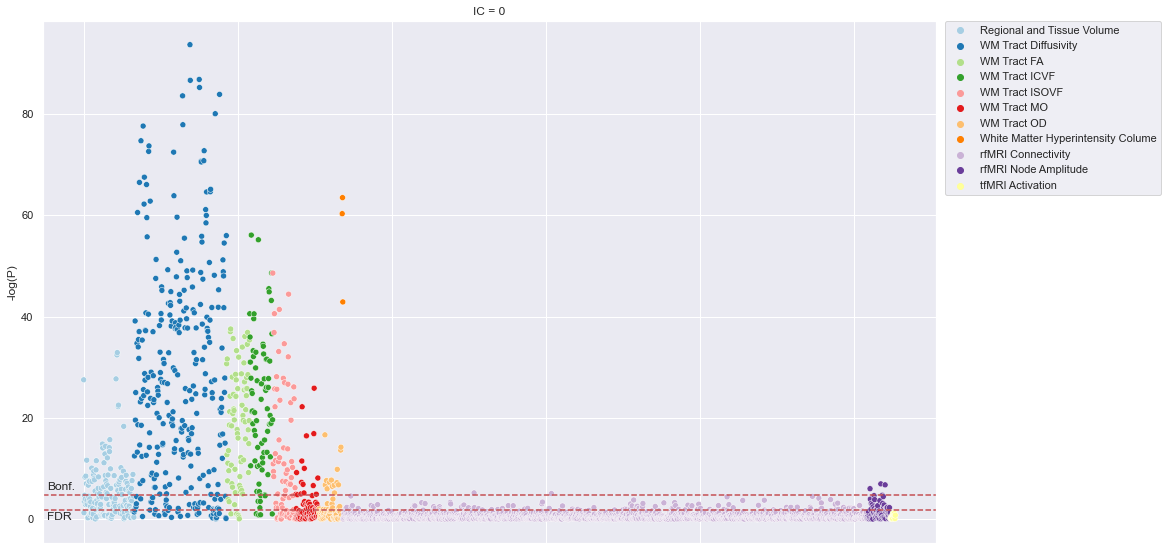

<ipython-input-3-004343bafa01>:159: RuntimeWarning: divide by zero encountered in log10
  "log_p_values": -np.log10(corr_results[3]),
<ipython-input-3-004343bafa01>:160: RuntimeWarning: divide by zero encountered in log10
  "log_p_values_corrected": -np.log10(corr_results[2]),


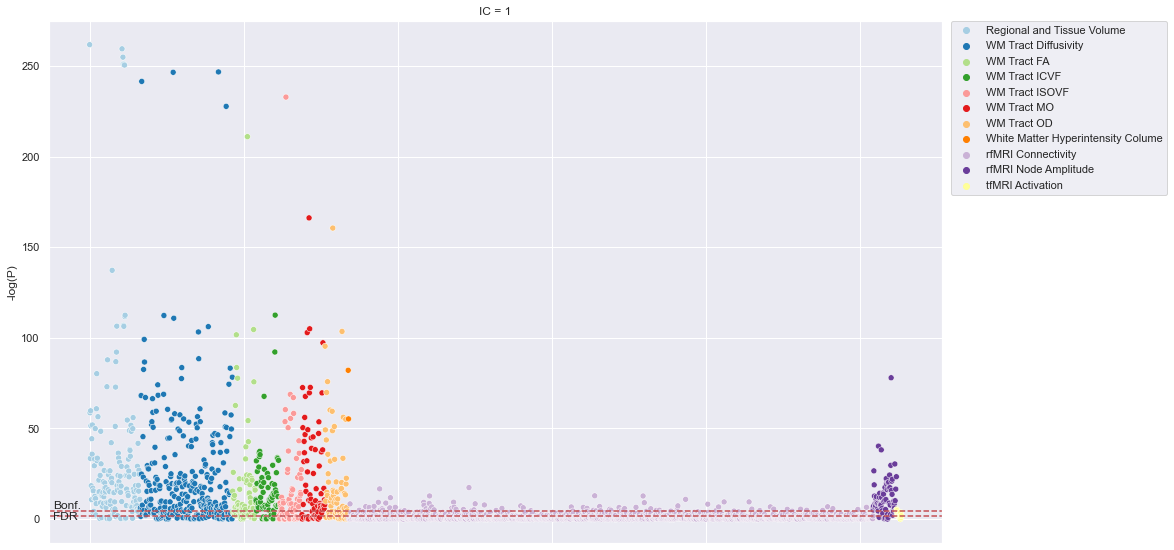

In [15]:
IDP_corrs = []
IDP_mods = []
IDP_bnf_thrs = []
IDP_fdr_thrs = []

for idx in range(len(icaS_df)):
    df_mod = icaS_df.iloc[idx].dataframe
    modality = icaS_df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
                                    names_subset = IDP_names_subset, idxs = IDPIDX_subset,
                                    categories_subset = IDP_categories_subset,
                                    title = modality, corr_flag='IDP')
    IDP_mods.append(modality)
    IDP_corrs.append(corr_df)
    IDP_bnf_thrs.append(bonferroni_threshold)
    IDP_fdr_thrs.append(false_discovery_rate)
    
IDP_df = pd.DataFrame.from_dict({
    'modality': IDP_mods,
    'bonf': IDP_bnf_thrs,
    'fdr': IDP_fdr_thrs,
    'dataframe': IDP_corrs
})

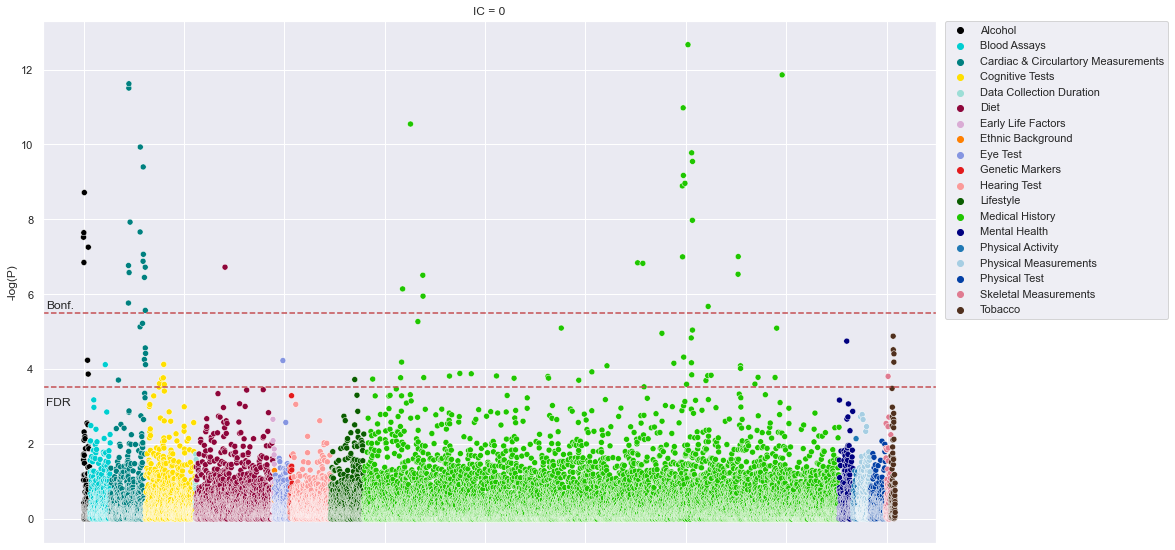

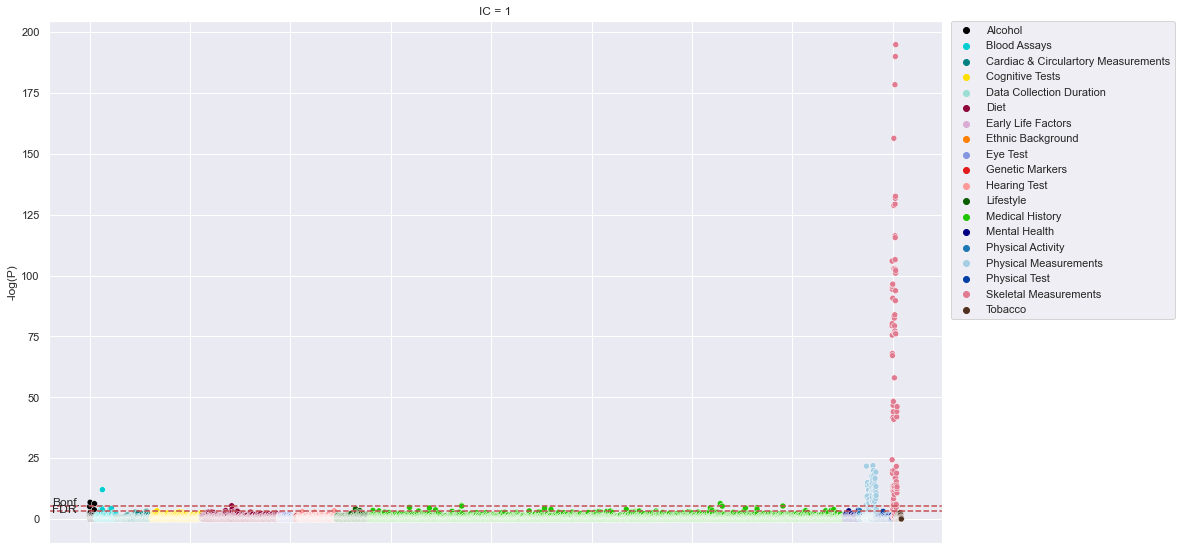

In [16]:
vars_corrs = []
vars_mods = []
vars_bnf_thrs = []
vars_fdr_thrs = []

for idx in range(len(icaS_df)):
    df_mod = icaS_df.iloc[idx].dataframe
    modality = icaS_df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
        print('BLA!')
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
                                    names_subset = varsHeader_subset, idxs = varsIDX_subset,
                                    categories_subset = vars_categories_subset,
                                    title = modality, corr_flag='vars')
    vars_mods.append(modality)
    vars_corrs.append(corr_df)
    vars_bnf_thrs.append(bonferroni_threshold)
    vars_fdr_thrs.append(false_discovery_rate)
    
vars_df = pd.DataFrame.from_dict({
    'modality': vars_mods,
    'bonf': vars_bnf_thrs,
    'fdr': vars_fdr_thrs,
    'dataframe': vars_corrs
})

In [17]:
IDP_df.to_pickle('female_subject_direction_ICA_deltas_IDP_STEVEnorm_deconf.pkl', protocol = 4)
vars_df.to_pickle('female_subject_direction_ICA_deltas_nIDP_STEVEnorm_deconf.pkl', protocol = 4)

# Analyse Subject-Direction Ages

In [18]:
# mat = scipy.io.loadmat(subjects_ages)
# icaA = mat['icaA']
# icaS = mat['icaS']
# pcaS = mat['pcaS']
# pcaU = mat['pcaU']
# pcaV = mat['pcaV']
# print("Shapes: ")
# print("icaA", icaA.shape)
# print("icaS", icaS.shape)
# print("pcaS", pcaS.shape)
# print("pcaU", pcaU.shape)
# print("pcaV", pcaV.shape)
# J = icaA.shape[0]
# pcaicaU = pcaU[:,:J].dot(pcaS[:J, :J]).dot(icaA)
# print("pcaicaU", pcaicaU.shape)

In [19]:
# dfx = df.iloc[0].dataframe
# dataframes = []
# names = []
# for idx in range(icaS.shape[0]):
#     if subjects_to_be_ignored[0] in dfx['Unnamed: 0'].to_list():
#         dfx_subjects = dfx['Unnamed: 0'].to_list()
#         dfx_subjects.remove(subjects_to_be_ignored[0])
#     comp_df = pd.DataFrame.from_dict({
#         'Unnamed: 0': dfx_subjects,
#         'age_delta_decon': icaS[idx, :]
#     })
#     names.append('IC = ' + str(idx))
#     dataframes.append(comp_df)
# icaS_df = pd.DataFrame.from_dict({'modality':names, 'dataframe':dataframes})

In [20]:
# icaS

In [21]:
# IDP_corrs = []
# IDP_mods = []
# IDP_bnf_thrs = []
# IDP_fdr_thrs = []

# for idx in range(len(icaS_df)):
#     df_mod = icaS_df.iloc[idx].dataframe
#     modality = icaS_df.iloc[idx].modality
#     age_delta_decon = df_mod.age_delta_decon.to_numpy()
#     subjects = df_mod['Unnamed: 0'].to_numpy()
#     subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
#                                                   age_delta_decon, subjects_to_be_ignored)
    
#     if deconfound_flag == True:
#         age_delta_decon = deconfound_inputs(age_delta_decon)
    
#     corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
#                                     age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
#                                     names_subset = IDP_names_subset, categories_subset = IDP_categories_subset,
#                                     title = modality, corr_flag='IDP')
#     IDP_mods.append(modality)
#     IDP_corrs.append(corr_df)
#     IDP_bnf_thrs.append(bonferroni_threshold)
#     IDP_fdr_thrs.append(false_discovery_rate)
    
# IDP_df = pd.DataFrame.from_dict({
#     'modality': IDP_mods,
#     'bonf': IDP_bnf_thrs,
#     'fdr': IDP_fdr_thrs,
#     'dataframe': IDP_corrs
# })

In [22]:
# vars_corrs = []
# vars_mods = []
# vars_bnf_thrs = []
# vars_fdr_thrs = []

# for idx in range(len(icaS_df)):
#     df_mod = icaS_df.iloc[idx].dataframe
#     modality = icaS_df.iloc[idx].modality
#     age_delta_decon = df_mod.age_delta_decon.to_numpy()
#     subjects = df_mod['Unnamed: 0'].to_numpy()
#     subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
#                                                   age_delta_decon, subjects_to_be_ignored)
    
#     if deconfound_flag == True:
#         age_delta_decon = deconfound_inputs(age_delta_decon)
    
#     corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
#                                     age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
#                                     names_subset = varsHeader_subset, 
#                                     categories_subset = vars_categories_subset,
#                                     title = modality, corr_flag='vars')
#     vars_mods.append(modality)
#     vars_corrs.append(corr_df)
#     vars_bnf_thrs.append(bonferroni_threshold)
#     vars_fdr_thrs.append(false_discovery_rate)
    
# vars_df = pd.DataFrame.from_dict({
#     'modality': vars_mods,
#     'bonf': vars_bnf_thrs,
#     'fdr': vars_fdr_thrs,
#     'dataframe': vars_corrs
# })

In [23]:
# IDP_df.to_pickle('female_subject_direction_ICA_ages_IDP_prototype_STEVEnorm_deconf.pkl', protocol = 4)
# vars_df.to_pickle('female_subject_direction_ICA_ages_nIDP_prototype_STEVEnorm_deconf.pkl', protocol = 4)

# Analyse Feature-Direction Deltas

In [24]:
mat = scipy.io.loadmat(modalities_deltas)
icaA = mat['icaA']
icaS = mat['icaS']
pcaS = mat['pcaS']
pcaU = mat['pcaU']
pcaV = mat['pcaV']
print("Shapes: ")
print("icaA", icaA.shape)
print("icaS", icaS.shape)
print("pcaS", pcaS.shape)
print("pcaU", pcaU.shape)
print("pcaV", pcaV.shape)
J = icaA.shape[0]
pcaicaU = pcaU[:,:J].dot(pcaS[:J, :J]).dot(icaA)
print("pcaicaU", pcaicaU.shape)

Shapes: 
icaA (2, 2)
icaS (2, 57)
pcaS (25, 25)
pcaU (5021, 25)
pcaV (57, 25)
pcaicaU (5021, 2)


In [25]:
dfx = df.iloc[0].dataframe
dataframes = []
names = []
for idx in range(icaS.shape[0]):
    if subjects_to_be_ignored[0] in dfx['Unnamed: 0'].to_list():
        dfx_subjects = dfx['Unnamed: 0'].to_list()
        dfx_subjects.remove(subjects_to_be_ignored[0])
    comp_df = pd.DataFrame.from_dict({
        'Unnamed: 0': dfx_subjects,
        'age_delta_decon': pcaicaU[:, idx]
    })
    names.append('IC = ' + str(idx))
    dataframes.append(comp_df)
icaS_df = pd.DataFrame.from_dict({'modality':names, 'dataframe':dataframes})

In [26]:
pcaicaU

array([[-0.06288724, -0.00230107],
       [ 0.10218478,  0.01797475],
       [ 0.12429823,  0.01107214],
       ...,
       [-0.06618509, -0.07214453],
       [ 0.08494847,  0.02111576],
       [-0.5529612 , -0.01913592]])

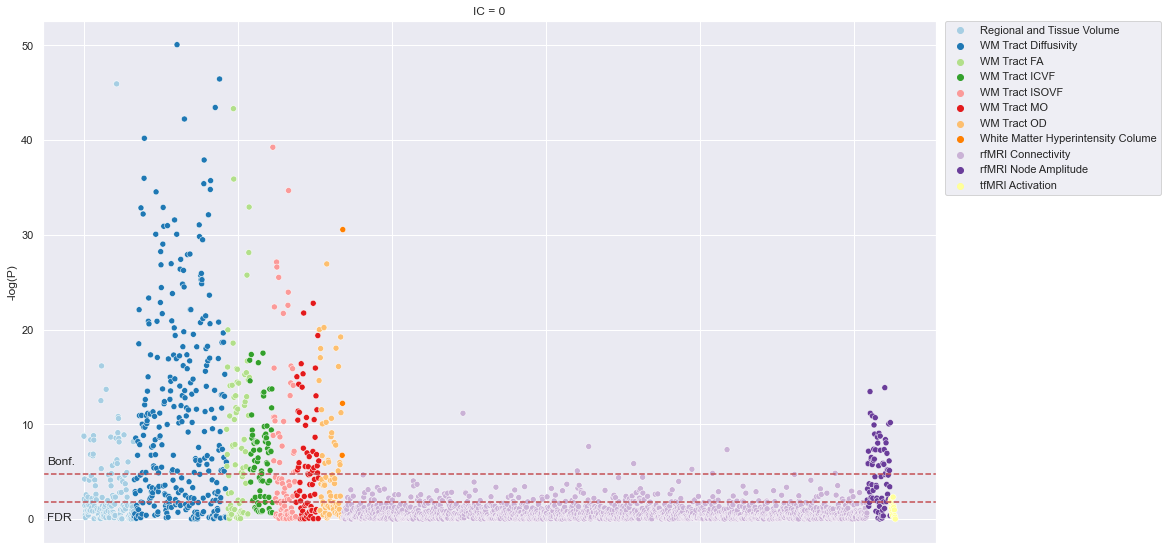

<ipython-input-3-004343bafa01>:159: RuntimeWarning: divide by zero encountered in log10
  "log_p_values": -np.log10(corr_results[3]),
<ipython-input-3-004343bafa01>:160: RuntimeWarning: divide by zero encountered in log10
  "log_p_values_corrected": -np.log10(corr_results[2]),


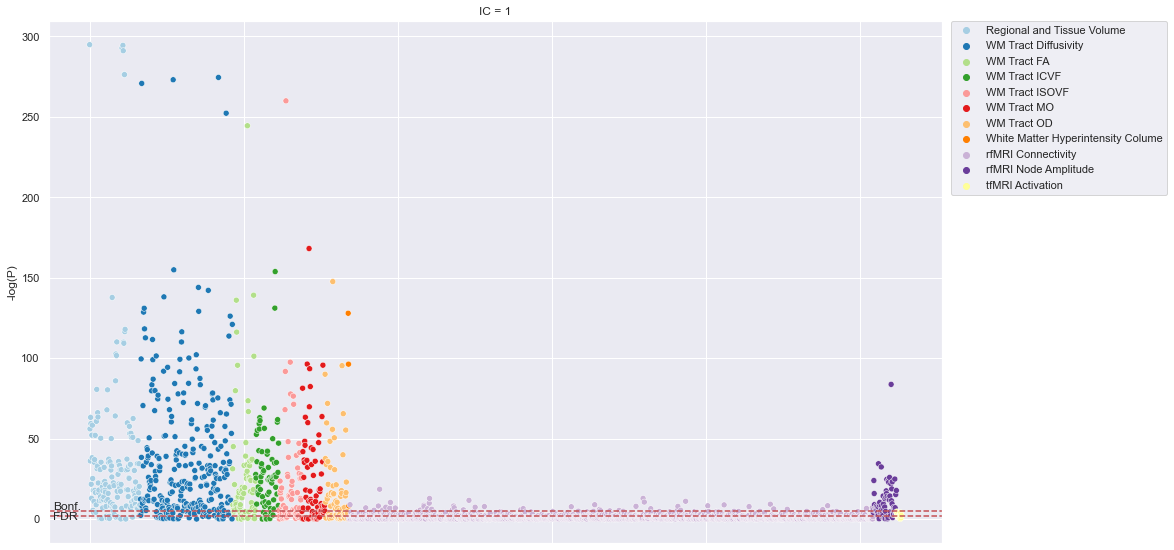

In [27]:
IDP_corrs = []
IDP_mods = []
IDP_bnf_thrs = []
IDP_fdr_thrs = []

for idx in range(len(icaS_df)):
    df_mod = icaS_df.iloc[idx].dataframe
    modality = icaS_df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
        print('Nldsada ')
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
                                    names_subset = IDP_names_subset, idxs = IDPIDX_subset,
                                    categories_subset = IDP_categories_subset,
                                    title = modality, corr_flag='IDP')
    IDP_mods.append(modality)
    IDP_corrs.append(corr_df)
    IDP_bnf_thrs.append(bonferroni_threshold)
    IDP_fdr_thrs.append(false_discovery_rate)
    
IDP_df = pd.DataFrame.from_dict({
    'modality': IDP_mods,
    'bonf': IDP_bnf_thrs,
    'fdr': IDP_fdr_thrs,
    'dataframe': IDP_corrs
})

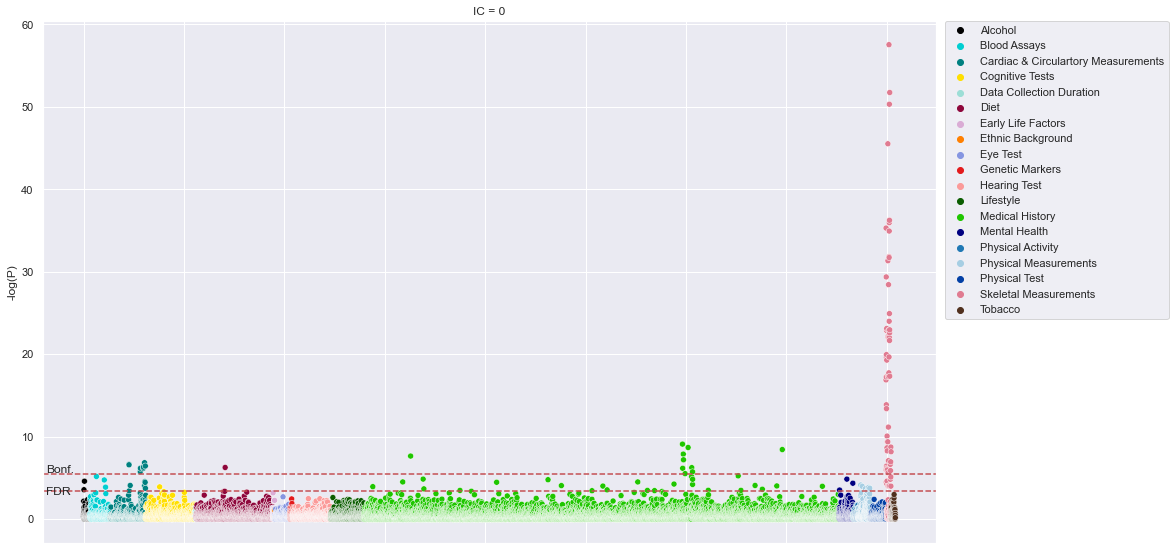

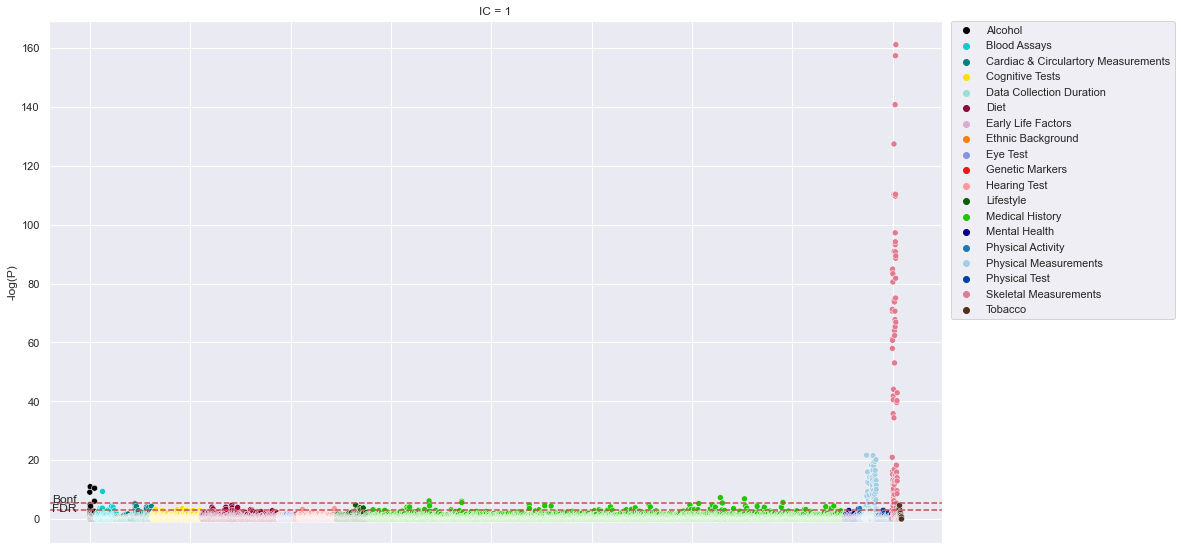

In [28]:
vars_corrs = []
vars_mods = []
vars_bnf_thrs = []
vars_fdr_thrs = []

for idx in range(len(icaS_df)):
    df_mod = icaS_df.iloc[idx].dataframe
    modality = icaS_df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
                                    names_subset = varsHeader_subset, idxs = varsIDX_subset,
                                    categories_subset = vars_categories_subset,
                                    title = modality, corr_flag='vars')
    vars_mods.append(modality)
    vars_corrs.append(corr_df)
    vars_bnf_thrs.append(bonferroni_threshold)
    vars_fdr_thrs.append(false_discovery_rate)
    
vars_df = pd.DataFrame.from_dict({
    'modality': vars_mods,
    'bonf': vars_bnf_thrs,
    'fdr': vars_fdr_thrs,
    'dataframe': vars_corrs
})

In [29]:
IDP_df.to_pickle('female_feature_direction_ICA_deltas_IDP_deconf_short.pkl', protocol = 4)
vars_df.to_pickle('female_feature_direction_ICA_deltas_nIDP_deconf_short.pkl', protocol = 4)

# Analyse Feature-Direction Ages

In [30]:
# mat = scipy.io.loadmat(modalities_ages)
# icaA = mat['icaA']
# icaS = mat['icaS']
# pcaS = mat['pcaS']
# pcaU = mat['pcaU']
# pcaV = mat['pcaV']
# print("Shapes: ")
# print("icaA", icaA.shape)

# print("icaS", icaS.shape)
# print("pcaS", pcaS.shape)
# print("pcaU", pcaU.shape)
# print("pcaV", pcaV.shape)
# J = icaA.shape[0]
# pcaicaU = pcaU[:,:J].dot(pcaS[:J, :J]).dot(icaA)
# print("pcaicaU", pcaicaU.shape)

In [31]:
# dfx = df.iloc[0].dataframe
# dataframes = []
# names = []
# for idx in range(icaS.shape[0]):
#     if subjects_to_be_ignored[0] in dfx['Unnamed: 0'].to_list():
#         dfx_subjects = dfx['Unnamed: 0'].to_list()
#         dfx_subjects.remove(subjects_to_be_ignored[0])
#     comp_df = pd.DataFrame.from_dict({
#         'Unnamed: 0': dfx_subjects,
#         'age_delta_decon': pcaicaU[:, idx]
#     })
#     names.append('IC = ' + str(idx))
#     dataframes.append(comp_df)
# icaS_df = pd.DataFrame.from_dict({'modality':names, 'dataframe':dataframes})

In [32]:
# pcaicaU

In [33]:
# IDP_corrs = []
# IDP_mods = []
# IDP_bnf_thrs = []
# IDP_fdr_thrs = []

# for idx in range(len(icaS_df)):
#     df_mod = icaS_df.iloc[idx].dataframe
#     modality = icaS_df.iloc[idx].modality
#     age_delta_decon = df_mod.age_delta_decon.to_numpy()
#     subjects = df_mod['Unnamed: 0'].to_numpy()
#     subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
#                                                   age_delta_decon, subjects_to_be_ignored)
    
#     if deconfound_flag == True:
#         age_delta_decon = deconfound_inputs(age_delta_decon)
    
#     corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
#                                     age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
#                                     names_subset = IDP_names_subset, categories_subset = IDP_categories_subset,
#                                     title = modality, corr_flag='IDP')
#     IDP_mods.append(modality)
#     IDP_corrs.append(corr_df)
#     IDP_bnf_thrs.append(bonferroni_threshold)
#     IDP_fdr_thrs.append(false_discovery_rate)
    
# IDP_df = pd.DataFrame.from_dict({
#     'modality': IDP_mods,
#     'bonf': IDP_bnf_thrs,
#     'fdr': IDP_fdr_thrs,
#     'dataframe': IDP_corrs
# })

In [34]:
# vars_corrs = []
# vars_mods = []
# vars_bnf_thrs = []
# vars_fdr_thrs = []

# for idx in range(len(icaS_df)):
#     df_mod = icaS_df.iloc[idx].dataframe
#     modality = icaS_df.iloc[idx].modality
#     age_delta_decon = df_mod.age_delta_decon.to_numpy()
#     subjects = df_mod['Unnamed: 0'].to_numpy()
#     subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
#                                                   age_delta_decon, subjects_to_be_ignored)
    
#     if deconfound_flag == True:
#         age_delta_decon = deconfound_inputs(age_delta_decon)
    
#     corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
#                                     age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
#                                     names_subset = varsHeader_subset, 
#                                     categories_subset = vars_categories_subset,
#                                     title = modality, corr_flag='vars')
#     vars_mods.append(modality)
#     vars_corrs.append(corr_df)
#     vars_bnf_thrs.append(bonferroni_threshold)
#     vars_fdr_thrs.append(false_discovery_rate)
    
# vars_df = pd.DataFrame.from_dict({
#     'modality': vars_mods,
#     'bonf': vars_bnf_thrs,
#     'fdr': vars_fdr_thrs,
#     'dataframe': vars_corrs
# })

In [35]:
# IDP_df.to_pickle('male_feature_direction_ICA_ages_IDP_prototype_deconf.pkl', protocol = 4)
# vars_df.to_pickle('male_feature_direction_ICA_ages_nIDP_prototype_deconf.pkl', protocol = 4)

In [36]:
# if deconfound_flag == True:
#     eng.quit()